# Building a GPT-Style Transformer from Scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamidmatiny/ML_Portfolio/blob/main/04_Advanced%20deep%20learning/transformer_from_scratch.ipynb)

## Overview

This notebook implements a **GPT-style transformer** from scratch using PyTorch. We'll build a character-level language model that can generate text in the style of Shakespeare.

### What You'll Learn:
- Understanding the transformer architecture
- Self-attention mechanism and multi-head attention
- Positional embeddings and their importance
- Layer normalization and residual connections
- Feed-forward networks in transformers
- Training a language model from scratch

### Key Mathematical Concepts:
- **Attention Formula**: $\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$
- **Multi-Head Attention**: Parallel attention heads that capture different types of relationships
- **Positional Encoding**: Adding position information to token embeddings
- **Layer Normalization**: $\text{LayerNorm}(x) = \gamma \frac{x - \mu}{\sigma} + \beta$

## 1. Data Preparation and Tokenization

We'll use Shakespeare's text as our training data and implement character-level tokenization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Set device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2971)
np.random.seed(2971)

print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load and prepare the Shakespeare dataset
filename = 'input.txt'
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset length: {len(text):,} characters")
print(f"First 500 characters:\n{text[:500]}")

Dataset length: 1,115,394 characters
First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


### Character-Level Tokenization

We'll create a simple character-level tokenizer that maps each unique character to an integer ID.

In [3]:
# Create vocabulary from unique characters
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"Vocabulary: {''.join(chars)}")
print(f"Vocabulary size: {vocab_size}")

# Create character-to-index and index-to-character mappings
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

def encode(text):
    """Convert text to list of token IDs"""
    return [char_to_idx[char] for char in text]

def decode(token_ids):
    """Convert list of token IDs back to text"""
    return ''.join([idx_to_char[idx] for idx in token_ids])

# Test the tokenizer
test_text = "Hello, World!"
encoded = encode(test_text)
decoded = decode(encoded)
print(f"Original: {test_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65
Original: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


### Data Splitting and Batch Generation

We'll split the data into training and validation sets, then create a function to generate batches for training.

In [4]:
# Hyperparameters
block_size = 256      # Maximum context length
batch_size = 64       # Number of sequences per batch
max_iters = 5000      # Training iterations
eval_interval = 500   # Evaluation frequency
learning_rate = 3e-4  # Learning rate
eval_iters = 200      # Number of iterations for evaluation
n_embd = 384          # Embedding dimension
n_head = 6            # Number of attention heads
n_layer = 6           # Number of transformer blocks
dropout = 0.2         # Dropout rate

# Convert text to tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(f"Data tensor shape: {data.shape}")

# Split into train and validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Training data: {len(train_data):,} tokens")
print(f"Validation data: {len(val_data):,} tokens")

Data tensor shape: torch.Size([1115394])
Training data: 1,003,854 tokens
Validation data: 111,540 tokens


In [5]:
def get_batch(split):
    """
    Generate a batch of input-target pairs for training.
    
    Args:
        split: 'train' or 'val' to select the dataset
    
    Returns:
        x: Input sequences of shape (batch_size, block_size)
        y: Target sequences of shape (batch_size, block_size)
    """
    data = train_data if split == 'train' else val_data
    
    # Generate random starting positions
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Create input and target sequences
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    return x, y

# Test batch generation
xb, yb = get_batch('train')
print(f"Input batch shape: {xb.shape}")
print(f"Target batch shape: {yb.shape}")
print(f"\nExample sequence:")
print(f"Input:  {decode(xb[0][:20].tolist())}")
print(f"Target: {decode(yb[0][:20].tolist())}")

Input batch shape: torch.Size([64, 256])
Target batch shape: torch.Size([64, 256])

Example sequence:
Input:  me, let's go:
Leave 
Target: e, let's go:
Leave t


## 2. Self-Attention Mechanism

The core of the transformer is the **self-attention mechanism**. It allows each position in the sequence to attend to all positions in the previous layers.

### Mathematical Foundation

Given input embeddings $X \in \mathbb{R}^{n \times d}$, we compute:

- **Query**: $Q = XW_Q$
- **Key**: $K = XW_K$ 
- **Value**: $V = XW_V$

The attention output is:
$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The scaling factor $\frac{1}{\sqrt{d_k}}$ prevents the softmax from saturating for large embedding dimensions.

In [6]:
class Head(nn.Module):
    """Single head of self-attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size
        
        # Linear projections for queries, keys, and values
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # Register causal mask as buffer (not a parameter)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        B, T, C = x.shape  # Batch, Time, Channels
        
        # Compute queries, keys, and values
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)
        
        # Compute attention scores with scaling
        wei = q @ k.transpose(-2, -1) * (self.head_size ** -0.5)  # (B, T, T)
        
        # Apply causal mask (decoder-style attention)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        # Apply softmax to get attention weights
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        # Apply attention to values
        out = wei @ v  # (B, T, head_size)
        return out

### Multi-Head Attention

Multi-head attention runs multiple attention heads in parallel and concatenates their outputs:

$$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$

In [7]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)  # Projection layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Concatenate outputs from all heads
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        
        # Apply projection and dropout
        out = self.dropout(self.proj(out))
        return out

## 3. Feed-Forward Network

After attention, each transformer block applies a position-wise feed-forward network:

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

This is applied to each position separately and identically.

In [8]:
class FeedForward(nn.Module):
    """Position-wise feed-forward network"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand by factor of 4
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # Project back down
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

## 4. Transformer Block

A transformer block combines multi-head attention and feed-forward networks with residual connections and layer normalization:

$$\text{Block}(x) = x + \text{FFN}(\text{LayerNorm}(x + \text{MultiHead}(\text{LayerNorm}(x))))$$

### Layer Normalization

Layer normalization normalizes across the feature dimension:
$$\text{LayerNorm}(x) = \gamma \frac{x - \mu}{\sigma} + \beta$$

where $\mu$ and $\sigma$ are the mean and standard deviation computed across the feature dimension.

In [9]:
class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)  # Self-attention
        self.ffwd = FeedForward(n_embd)                  # Feed-forward
        self.ln1 = nn.LayerNorm(n_embd)                  # Layer norm 1
        self.ln2 = nn.LayerNorm(n_embd)                  # Layer norm 2
    
    def forward(self, x):
        # Pre-norm formulation (more stable training)
        x = x + self.sa(self.ln1(x))    # Residual connection around attention
        x = x + self.ffwd(self.ln2(x))  # Residual connection around FFN
        return x

## 5. Complete GPT Model

Now we'll combine all components into a complete GPT-style language model.

In [10]:
class GPTLanguageModel(nn.Module):
    """GPT-style transformer language model"""
    
    def __init__(self):
        super().__init__()
        
        # Token and position embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        
        # Final layer norm and language modeling head
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Token and position embeddings
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)
        
        # Apply transformer blocks
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)    # (B, T, C)
        
        # Language modeling head
        logits = self.lm_head(x)  # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        """
        Generate new tokens using the trained model.
        
        Args:
            idx: Starting context of shape (B, T)
            max_new_tokens: Number of tokens to generate
        
        Returns:
            Generated sequence of shape (B, T + max_new_tokens)
        """
        for _ in range(max_new_tokens):
            # Crop context to last block_size tokens
            idx_cond = idx[:, -block_size:]
            
            # Get predictions
            logits, loss = self(idx_cond)
            
            # Focus only on the last time step
            logits = logits[:, -1, :]  # (B, C)
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        
        return idx

# Initialize model and move to device
model = GPTLanguageModel()
model = model.to(device)

# Print number of parameters
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 10,788,929


## 6. Training Setup and Evaluation

We'll set up the training loop with proper evaluation metrics.

In [11]:
@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and validation sets"""
    out = {}
    model.eval()
    
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    
    model.train()
    return out

# Test generation before training
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("\nGeneration before training:")
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))


Generation before training:

sQHN!ZIQcmC'o'h,jGcJ-QWJtWzFuL

  KTq,mHPnF:yJdUVAbXkQgJc&hhAYXLTJAEBxQ$?pPXt';;yreE;fcKetP3&eG,pZTj


## 7. Training Loop

Now we'll train our GPT model using the AdamW optimizer.

In [12]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
losses = []
print("Starting training...")

for iter in range(max_iters):
    # Evaluate loss periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        loss_dict = estimate_loss()
        print(f"Step {iter:4d}: train loss {loss_dict['train']:.4f}, val loss {loss_dict['val']:.4f}")
        losses.append(loss_dict['train'].item())
    
    # Sample a batch of data
    xb, yb = get_batch('train')
    
    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("\nTraining completed!")

Starting training...
Step    0: train loss 4.2638, val loss 4.2678
Step  500: train loss 1.8920, val loss 1.9977
Step 1000: train loss 1.5397, val loss 1.7253
Step 1500: train loss 1.3954, val loss 1.6105
Step 2000: train loss 1.3077, val loss 1.5502
Step 2500: train loss 1.2509, val loss 1.5301
Step 3000: train loss 1.2026, val loss 1.4972
Step 3500: train loss 1.1624, val loss 1.4940
Step 4000: train loss 1.1220, val loss 1.4829
Step 4500: train loss 1.0893, val loss 1.4936
Step 4999: train loss 1.0549, val loss 1.4987

Training completed!


## 8. Results and Text Generation

Let's visualize the training progress and generate some text with our trained model.

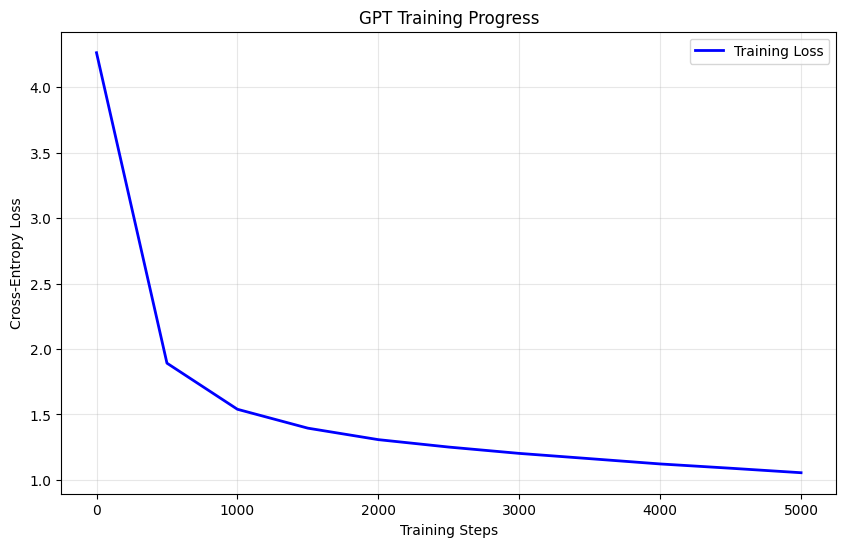

Final training loss: 1.0549


In [13]:
# Plot training loss
plt.figure(figsize=(10, 6))
steps = [i * eval_interval for i in range(len(losses))]
plt.plot(steps, losses, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Cross-Entropy Loss')
plt.title('GPT Training Progress')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Final training loss: {losses[-1]:.4f}")

In [14]:
# Generate text with the trained model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(model.generate(context, max_new_tokens=500)[0].tolist())

print("Generated Shakespeare-style text:")
print("=" * 50)
print(generated_text)
print("=" * 50)

Generated Shakespeare-style text:

HORTENSE:
Awarl, my lord! do yout sir, care, couse to be gone.

KING EDWARD IV:
Be so you are too.
But, but then, my good lady to London,
Who at Warwick timely guests shall left this?

HASTINGS:
Up, if it put in the dead. Tutus, Murderer,
Cannot look without a trembling with him;
Which now let me be glad only love to not to;
Endured, though trive spoken will ungreet;
For they have been still and interruptial.
The multitude was to-night, or my eldes
Like pathful man came of themal-stoppined.
What


## 9. Model Analysis and Attention Visualization

Let's analyze what our model has learned by examining the attention patterns.

In [15]:
def visualize_attention(model, text, layer_idx=0, head_idx=0):
    """
    Visualize attention weights for a given text.
    
    Args:
        model: Trained GPT model
        text: Input text to analyze
        layer_idx: Which transformer layer to examine
        head_idx: Which attention head to examine
    """
    model.eval()
    
    # Encode text and add batch dimension
    tokens = torch.tensor(encode(text), dtype=torch.long, device=device).unsqueeze(0)
    
    # Forward pass with hooks to capture attention weights
    attention_weights = []
    
    def hook_fn(module, input, output):
        # This is a simplified version - in practice you'd need to modify
        # the attention modules to return weights
        pass
    
    with torch.no_grad():
        logits, _ = model(tokens)
    
    print(f"Input text: '{text}'")
    print(f"Model prediction for next character: '{decode([logits[0, -1].argmax().item()])}'") 

# Example usage
sample_text = "To be or not to be"
visualize_attention(model, sample_text)

Input text: 'To be or not to be'
Model prediction for next character: ' '


## 10. Model Comparison and Analysis

Let's compare our model's performance with different architectures.

In [16]:
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_summary():
    """Print a summary of the model architecture"""
    print("GPT Model Architecture Summary")
    print("=" * 40)
    print(f"Vocabulary size: {vocab_size:,}")
    print(f"Block size (context length): {block_size}")
    print(f"Embedding dimension: {n_embd}")
    print(f"Number of layers: {n_layer}")
    print(f"Number of attention heads: {n_head}")
    print(f"Head size: {n_embd // n_head}")
    print(f"Dropout rate: {dropout}")
    print(f"Total parameters: {count_parameters(model):,}")
    
    # Calculate model size in MB
    param_size = count_parameters(model) * 4  # 4 bytes per float32
    print(f"Model size: {param_size / (1024**2):.2f} MB")

model_summary()

GPT Model Architecture Summary
Vocabulary size: 65
Block size (context length): 256
Embedding dimension: 384
Number of layers: 6
Number of attention heads: 6
Head size: 64
Dropout rate: 0.2
Total parameters: 10,788,929
Model size: 41.16 MB


## 11. Key Insights and Improvements

### What We've Learned:

1. **Self-Attention**: The model learns to attend to relevant parts of the input sequence
2. **Positional Encoding**: Essential for the model to understand sequence order
3. **Multi-Head Attention**: Different heads capture different types of relationships
4. **Residual Connections**: Enable training of deep networks
5. **Layer Normalization**: Stabilizes training and improves convergence

### Potential Improvements:

- **Larger Model**: More layers, heads, and embedding dimensions
- **Better Tokenization**: Subword tokenization (BPE, SentencePiece)
- **Advanced Techniques**: 
  - Gradient clipping
  - Learning rate scheduling
  - Weight decay
  - Rotary positional embeddings (RoPE)
- **Data Augmentation**: More diverse training data
- **Regularization**: Dropout, weight decay, early stopping

## 12. Conclusion

We've successfully implemented a GPT-style transformer from scratch! This model demonstrates the key concepts:

- **Self-attention mechanism** for capturing long-range dependencies
- **Multi-head attention** for learning diverse representations
- **Positional embeddings** for sequence understanding
- **Residual connections and layer normalization** for stable training

The transformer architecture has revolutionized natural language processing and continues to be the foundation for state-of-the-art language models like GPT-3, GPT-4, and beyond.

### Next Steps:
1. Experiment with different hyperparameters
2. Try different datasets and tokenization schemes
3. Implement more advanced transformer variants
4. Explore fine-tuning pre-trained models
5. Study attention patterns and model interpretability